# 分类MNIST手写数字数据集

<div class="alert alert-block alert-info">
Shift + Enter 运行单元格中的代码<br>
双击单元格进入编辑模式，即可修改代码。<br>
</div>


![jupyter](http://jupyter.org/assets/main-logo.svg)

本案例，将使用Pytorch搭建卷积神经网络，对著名的手写数字数据集MNIST的七万张图片进行分类，包含完整的多层感知机模型定义、损失函数、优化器超参数设置、梯度下降与反向传播训练神经网络、可视化训练过程的误差下降，用测试集的一万张图片进行模型评估，并**分析被分类错误的图片具有哪些特征，神经网络为什么会将这些图片分类错误？哪些图片最容易被错分类？最容易被错分到哪一类？**


# 1.导入工具库

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签  
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

# 2.设定超参数

In [2]:
# 查看你的电脑是否支持gpu加速,就算返回False也没关系
use_cuda = torch.cuda.is_available()    #gpu是否可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
input_size = 784 # 输入数据的维度，28*28=784
# hidden_size = 128 # 隐含层神经元个数
# num_classes = 10 # 输出层神经元个数，每个神经元对应一类的概率
num_epochs = 5 # 迭代轮次，完整处理完训练集中所有的数据是一轮
batch_size = 100 # 每一批数据大小
learning_rate = 0.001 # 学习率

我们将构建包含一个隐含层的多层感知机(全连接多层神经网络)，输入为784维的数据，隐含层128个神经元，输出层10个神经元，分别输出图片在0-9十个分类上的概率。

下图展示了两个隐含层多层感知机神经网络的基本架构，我们构建的神经网络只包含一个隐含层，与动图中稍有不同


# 3.导入数据集

In [4]:
# 载入MNIST手写数字数据集
# 载入训练集
train_dataset = torchvision.datasets.MNIST(root='../data/', 
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=False)
# 载入测试集
test_dataset = torchvision.datasets.MNIST(root='../data/',
                                          train=False, 
                                          transform=transforms.ToTensor(),
                                          )

# Data loader构建输入数据加载器，这个加载器是一个python生成器，可以认为是一个流水线，每次都返回一批新数据
# 训练集数据载入流水线
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
# 测试集数据载入流水线
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

## 可视化数据

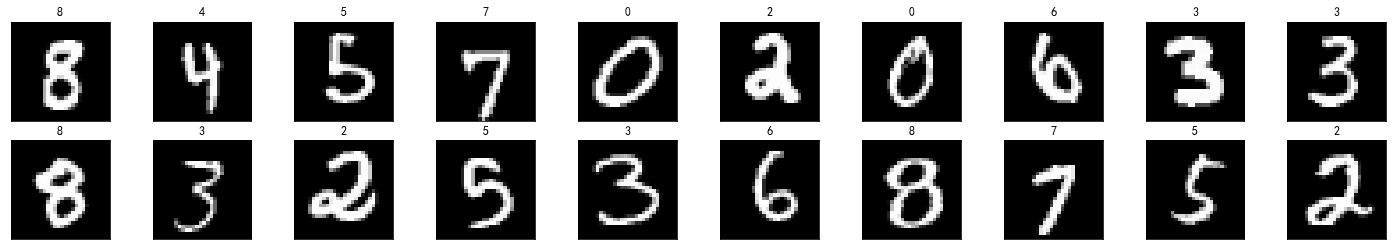

In [5]:
# 可重复运行，展示不同的图片

# 构造迭代器，获得训练集中的一批次数据
dataiter = iter(train_loader)
images, labels = dataiter.next()
# 将数据集中的Tensor张量转为numpy的array数据类型
images = images.numpy()

# 可视化图片和标签
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # .item()获取张量的数值
    ax.set_title(str(labels[idx].item()))

Text(0.5, 1.0, 'label:tensor(4)')

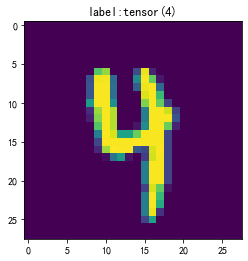

In [6]:
plt.imshow(images[1][0])
plt.title('label:'+str(labels[1]))

## 展示图像的像素细节

In [7]:
images[1].shape

(1, 28, 28)

In [8]:
np.squeeze(images[1]).shape

(28, 28)

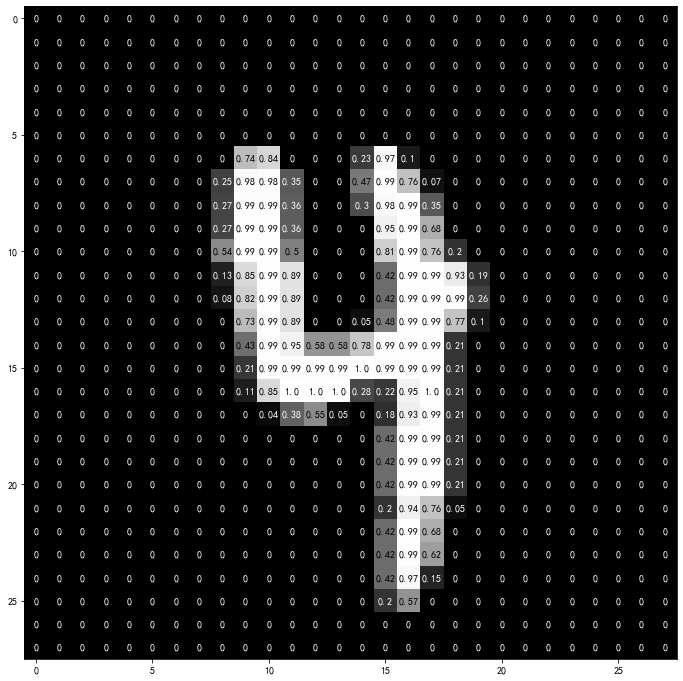

In [9]:
# 去掉图像的批次维度，只保留索引为1的单张图像的长宽像素值
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5

# 遍历每一行每一列每一个像素
for x in range(width):
    for y in range(height):
        # 像素值保留两位小数，如果为0则显示0
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

# 4.构建模型、定义损失与优化器

In [10]:
# 添加隐层，构建多层感知器
class ConvolutionalNeural(nn.Module):
    def __init__(self):
        super(ConvolutionalNeural, self).__init__()
        # 输入1通道，输出10通道，kernel 5*5
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.mp = nn.MaxPool2d(2)
        # fully connect
        self.fc = nn.Linear(320, 10)

    def forward(self, x):
        # in_size = 64
        in_size = x.size(0) # one batch
        # x: 64*10*12*12
        x = F.relu(self.mp(self.conv1(x)))
        # x: 64*20*4*4
        x = F.relu(self.mp(self.conv2(x)))
        # x: 64*320
        x = x.view(in_size, -1) # flatten the tensor
        # x: 64*10
        x = self.fc(x)
        return F.log_softmax(x)

model = ConvolutionalNeural ().to(device)
# if use_cuda:
#     model.cuda()
model
# 多分类问题使用交叉熵损失，使用Adam优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

# 5.模型训练

In [11]:
len(train_loader)

600

In [12]:
# 训练模型 每打印一次调试信息表示过了一万张图片 （每步批次100张图片，每100步打印一次调试信息）
# 每一轮 = 六万张图片 = 600步 = 打印六次调试信息
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # 转到gpu设备上
        images = images.cuda(device)
        labels = labels.cuda(device)
        # if use_cuda:
        #     images.cuda()
        #     labels.cuda()
        # 前向运算
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('目前总轮次进程 [{}/{}], 当前批次进程 [{}/{}], 当前损失: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

d:\codeing\python\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


目前总轮次进程 [1/5], 当前批次进程 [100/600], 当前损失: 0.3414
目前总轮次进程 [1/5], 当前批次进程 [200/600], 当前损失: 0.2506
目前总轮次进程 [1/5], 当前批次进程 [300/600], 当前损失: 0.3307
目前总轮次进程 [1/5], 当前批次进程 [400/600], 当前损失: 0.0842
目前总轮次进程 [1/5], 当前批次进程 [500/600], 当前损失: 0.0657
目前总轮次进程 [1/5], 当前批次进程 [600/600], 当前损失: 0.0660
目前总轮次进程 [2/5], 当前批次进程 [100/600], 当前损失: 0.0822
目前总轮次进程 [2/5], 当前批次进程 [200/600], 当前损失: 0.0976
目前总轮次进程 [2/5], 当前批次进程 [300/600], 当前损失: 0.1095
目前总轮次进程 [2/5], 当前批次进程 [400/600], 当前损失: 0.1080
目前总轮次进程 [2/5], 当前批次进程 [500/600], 当前损失: 0.1036
目前总轮次进程 [2/5], 当前批次进程 [600/600], 当前损失: 0.0741
目前总轮次进程 [3/5], 当前批次进程 [100/600], 当前损失: 0.0991
目前总轮次进程 [3/5], 当前批次进程 [200/600], 当前损失: 0.0981
目前总轮次进程 [3/5], 当前批次进程 [300/600], 当前损失: 0.0524
目前总轮次进程 [3/5], 当前批次进程 [400/600], 当前损失: 0.0737
目前总轮次进程 [3/5], 当前批次进程 [500/600], 当前损失: 0.0278
目前总轮次进程 [3/5], 当前批次进程 [600/600], 当前损失: 0.0393
目前总轮次进程 [4/5], 当前批次进程 [100/600], 当前损失: 0.0311
目前总轮次进程 [4/5], 当前批次进程 [200/600], 当前损失: 0.0310
目前总轮次进程 [4/5], 当前批次进程 [300/600], 当前损失: 0.0354
目前总轮次进程 [4/5], 当前批次进程 [400/600], 当

# 6.预估与测试集评估

In [13]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        # if use_cuda:
        #     images.cuda()
        #     labels.cuda()
        images = images.cuda(device)
        labels = labels.cuda(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('10000张测试图片上的准确率为 {} %'.format(100 * correct / total))

# 模型存储
torch.save(model.state_dict(), './mlp.ckpt')

d:\codeing\python\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


10000张测试图片上的准确率为 98 %


# 7.增加可视化内容，重新训练和评估，分析分类错误的图片

In [15]:
# 重新训练 绘制错误率曲线 画出分类错误的图片
# 训练模型 

# model = ConvolutionalNeural ().to(device)
model = ConvolutionalNeural ().cuda(device)
if use_cuda:
    model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

loss_list = [] # 每1步存储一次损失值
loss_list2 = [] # 每100步存储一次损失值
total_step = len(train_loader)
print('开始在训练集上训练')
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # 转到gpu设备上
        images = images.cuda(device)
        labels = labels.cuda(device)
        # if use_cuda:
        #     images.cuda()
        #     labels.cuda()
        # 前向运算
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 每100步输出一次，每输出一次表示过了一万张图片 （每步，也就是每批次包含100张图片，每100步输出一次调试信息）
        if (i+1) % 100 == 0:
            loss_list2.append(loss.item())
            print ('目前总轮次进程 [{}/{}], 当前批次进程 [{}/{}], 当前损失: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

开始在训练集上训练
目前总轮次进程 [1/5], 当前批次进程 [100/600], 当前损失: 0.3360
目前总轮次进程 [1/5], 当前批次进程 [200/600], 当前损失: 0.2369
目前总轮次进程 [1/5], 当前批次进程 [300/600], 当前损失: 0.2994
目前总轮次进程 [1/5], 当前批次进程 [400/600], 当前损失: 0.0509
目前总轮次进程 [1/5], 当前批次进程 [500/600], 当前损失: 0.1086
目前总轮次进程 [1/5], 当前批次进程 [600/600], 当前损失: 0.2223
目前总轮次进程 [2/5], 当前批次进程 [100/600], 当前损失: 0.1283
目前总轮次进程 [2/5], 当前批次进程 [200/600], 当前损失: 0.1425
目前总轮次进程 [2/5], 当前批次进程 [300/600], 当前损失: 0.1421
目前总轮次进程 [2/5], 当前批次进程 [400/600], 当前损失: 0.0257
目前总轮次进程 [2/5], 当前批次进程 [500/600], 当前损失: 0.0899
目前总轮次进程 [2/5], 当前批次进程 [600/600], 当前损失: 0.1386
目前总轮次进程 [3/5], 当前批次进程 [100/600], 当前损失: 0.0670
目前总轮次进程 [3/5], 当前批次进程 [200/600], 当前损失: 0.0461
目前总轮次进程 [3/5], 当前批次进程 [300/600], 当前损失: 0.0351
目前总轮次进程 [3/5], 当前批次进程 [400/600], 当前损失: 0.0293
目前总轮次进程 [3/5], 当前批次进程 [500/600], 当前损失: 0.0464
目前总轮次进程 [3/5], 当前批次进程 [600/600], 当前损失: 0.0206
目前总轮次进程 [4/5], 当前批次进程 [100/600], 当前损失: 0.0347
目前总轮次进程 [4/5], 当前批次进程 [200/600], 当前损失: 0.0241
目前总轮次进程 [4/5], 当前批次进程 [300/600], 当前损失: 0.0094
目前总轮次进程 [4/5], 当前批次进程 [4

d:\codeing\python\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


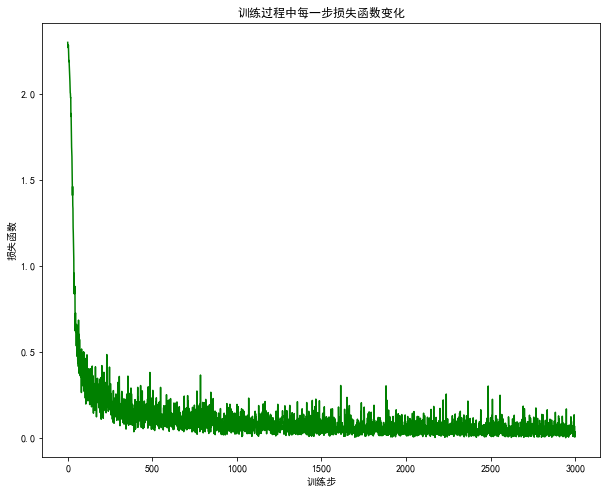

In [16]:
# 绘制训练过程中每一步的损失函数值
# 每一步，也就是每一批次，训练时用了100张图片
# 每一个epoch（训练集六万张图片）需要600步，5个epoch需要3000步，所以横坐标到3000
plt.figure(figsize=(10, 8))
plt.plot(loss_list,'g-')
plt.xlabel('训练步')
plt.ylabel('损失函数')
plt.title('训练过程中每一步损失函数变化')
plt.show()

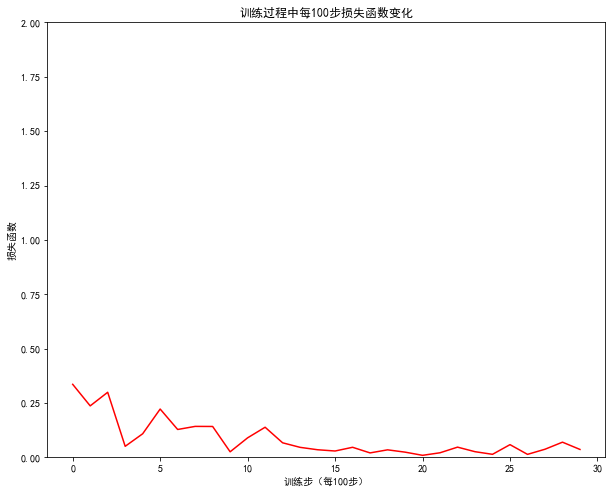

In [17]:
# 每100步的训练函数下降曲线
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 8))
plt.plot(loss_list2,'r-')
plt.ylim((0,2))
plt.xlabel('训练步（每100步）')
plt.ylabel('损失函数')
plt.title('训练过程中每100步损失函数变化')
plt.show()

In [25]:
# 在测试集的一万张图片上做测试，并存储分类错误的图片、它们对应的真实标签和预测结果
with torch.no_grad():
    correct = 0
    total = 0
    # 构建三个空列表，用于存放被分类错误的图片，以及对应的真实标签和预测结果
    wrong_image = [] # 用于存放被分类错误的图片
    wrong_image_label = [] # 用于存放被分类错误的图片的真实标签
    wrong_image_pred = []  # 用于存放被分类错误的图片的错误预测结果
    for images, labels in test_loader:
        images = images.cuda(device)
        labels = labels.cuda(device)
        # if use_cuda:
        #     images.cuda()
        #     labels.cuda()
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        # _, predicted = outputs.argmax()
        total += labels.size(0)
        correct += (predicted == labels).sum()
        
        # 找出分类错误的图片，以及对应的真实标签和预测结果，分别放在三个列表里
        pred_result = np.argmax(outputs.cpu().clone().numpy(),axis=1) # 找到模型推断的每张图片所属的类别
        labels = labels.cpu().clone().numpy()# 将标签转为numpy的array数组
        final = (pred_result == labels) # 被分类正确的为True，被分类错误的为False
        wrong_index = np.where(final==False)[0] # 获取被分类错误的图片索引号
        
        for i in range(images[wrong_index].shape[0]):
            wrong_image.append(images[wrong_index][i]) # 存储被分类错误的图片
            wrong_image_label.append(labels[wrong_index][i]) # 存储被分类错误的图片对应的真实标签
            wrong_image_pred.append(pred_result[wrong_index][i]) # 存储被分类错误的图片的错误预测结果

    print('10000张测试图片上的准确率为 {} %'.format(100 * correct / total))
    print('有{}张图片被分类错误'.format(len(wrong_image_label)))

d:\codeing\python\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


10000张测试图片上的准确率为 98 %
有148张图片被分类错误


In [26]:
# 模型推断的类别
pred_result

array([8, 9, 0, 1, 8, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 7, 8, 9, 7, 8, 6,
       4, 1, 9, 3, 8, 4, 4, 7, 0, 1, 9, 2, 8, 7, 8, 2, 6, 0, 6, 5, 3, 3,
       3, 9, 1, 4, 0, 6, 1, 0, 0, 6, 2, 1, 1, 7, 7, 8, 4, 6, 0, 7, 0, 3,
       6, 8, 7, 1, 5, 2, 4, 9, 4, 3, 6, 4, 1, 7, 2, 6, 6, 0, 1, 2, 3, 4,
       5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [27]:
# 实际的类别
labels

array([8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 7, 8, 9, 7, 8, 6,
       4, 1, 9, 3, 8, 4, 4, 7, 0, 1, 9, 2, 8, 7, 8, 2, 6, 0, 6, 5, 3, 3,
       3, 9, 1, 4, 0, 6, 1, 0, 0, 6, 2, 1, 1, 7, 7, 8, 4, 6, 0, 7, 0, 3,
       6, 8, 7, 1, 5, 2, 4, 9, 4, 3, 6, 4, 1, 7, 2, 6, 5, 0, 1, 2, 3, 4,
       5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [28]:
final

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [29]:
len(wrong_image)

148

In [30]:
len(wrong_image_label)

148

In [31]:
len(wrong_image_pred)

148

真实类别: 6
模型猜测的类别: 0


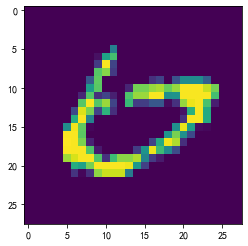

In [33]:
# 可视化分类错误图片中索引为i的图像，打印它的真实类别、模型猜测的类别
i = 3
plt.imshow(wrong_image[i].cpu().clone().numpy().reshape(28,28))
print('真实类别:',wrong_image_label[i])
print('模型猜测的类别:',wrong_image_pred[i])

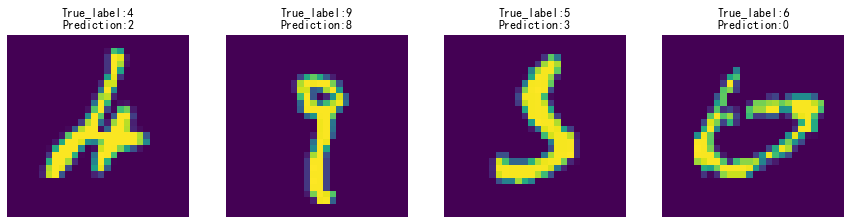

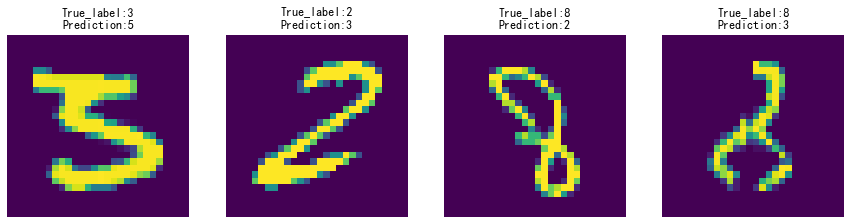

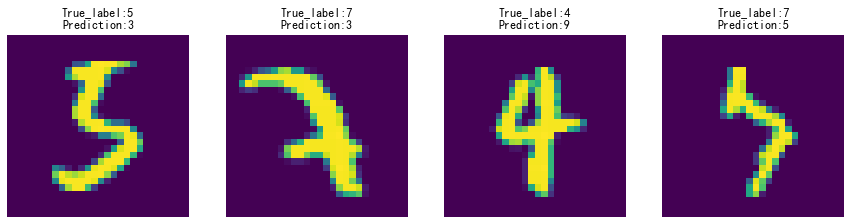

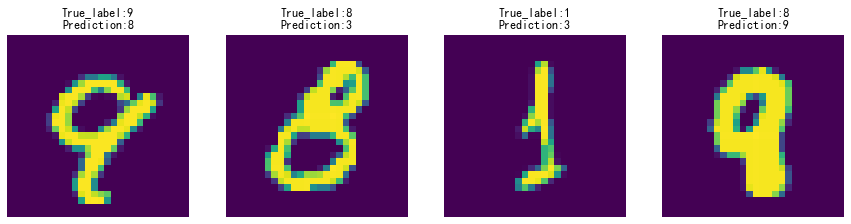

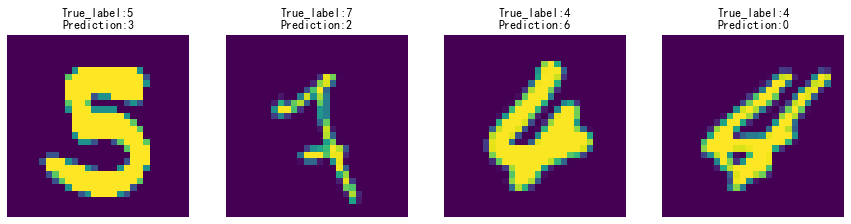

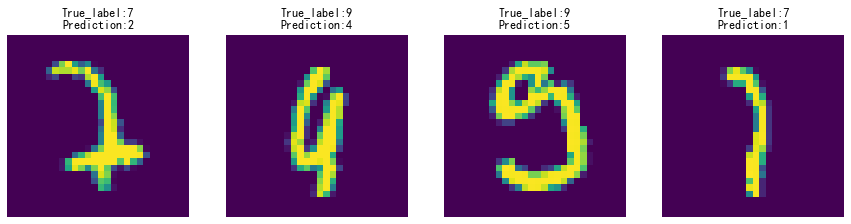

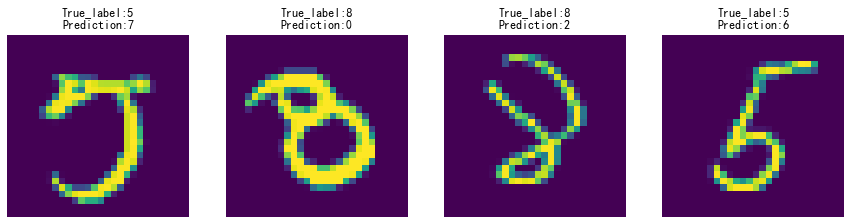

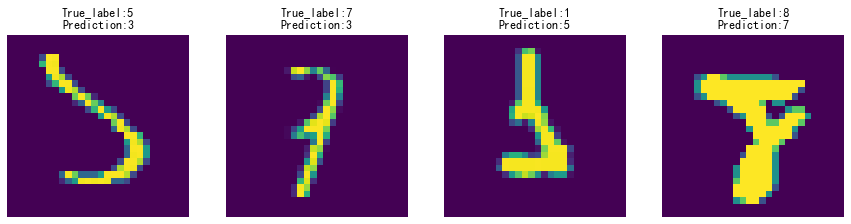

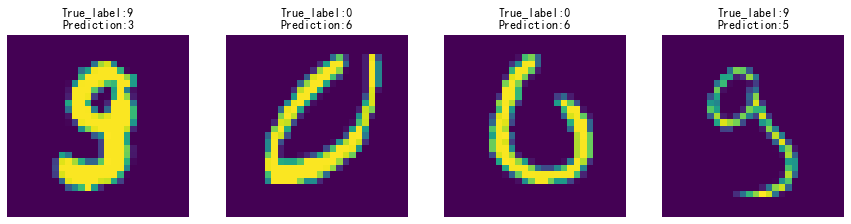

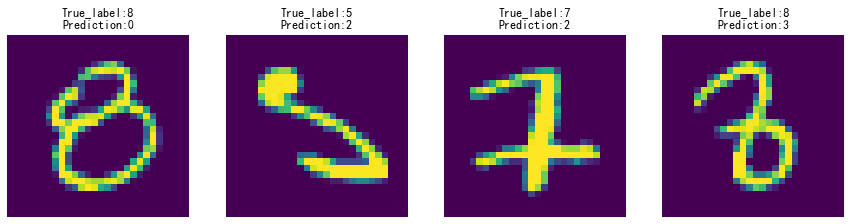

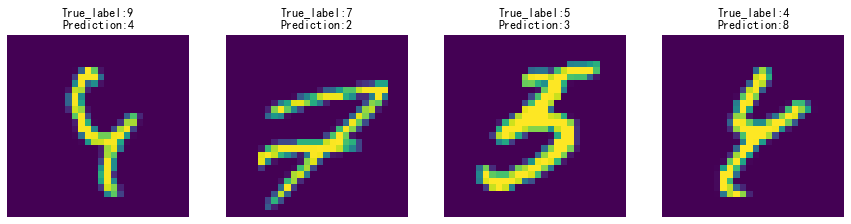

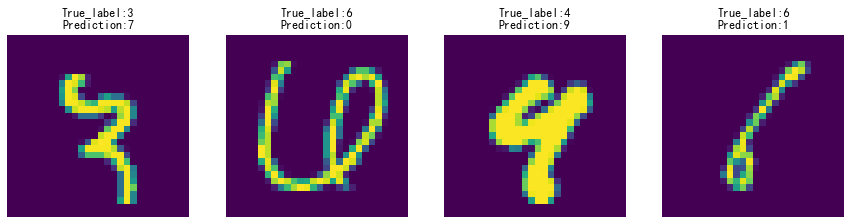

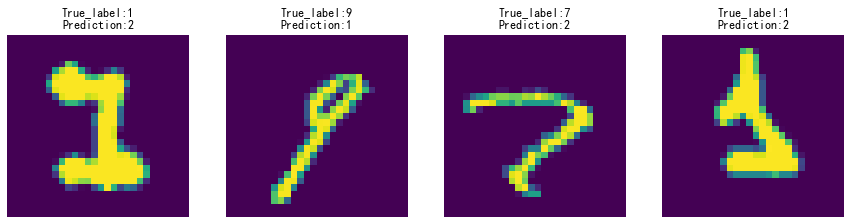

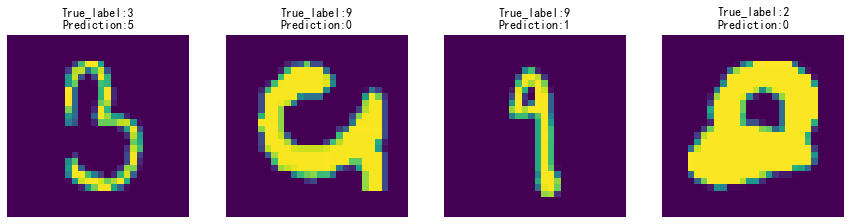

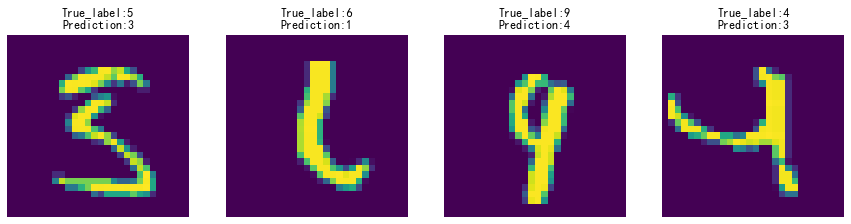

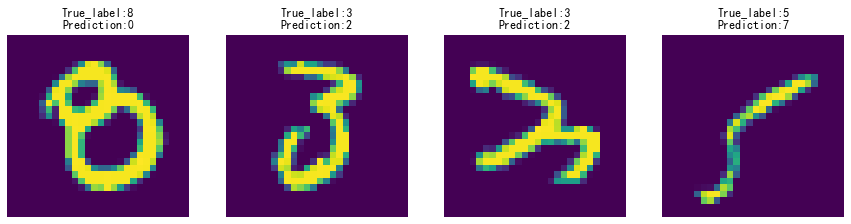

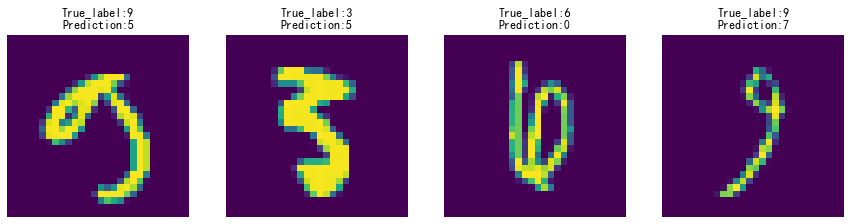

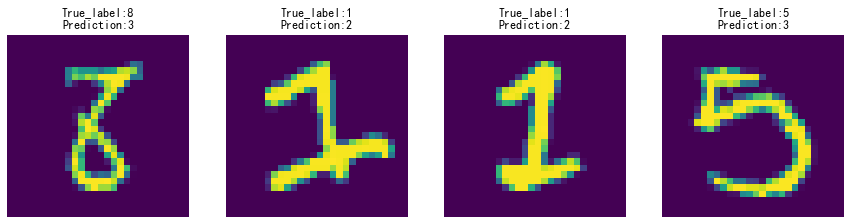

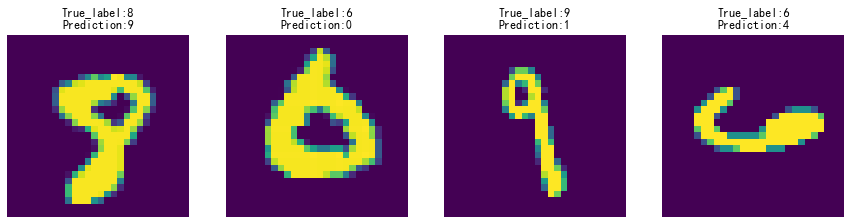

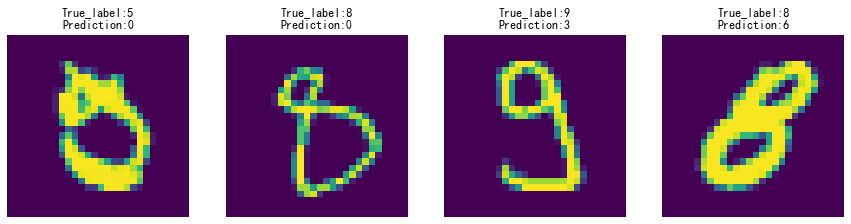

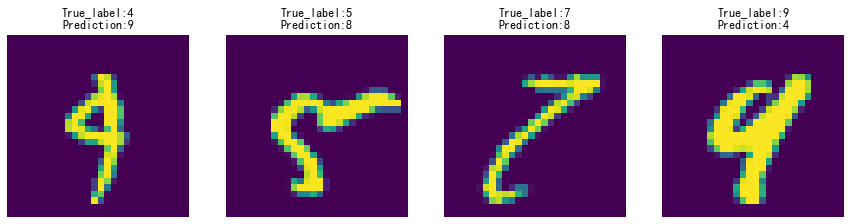

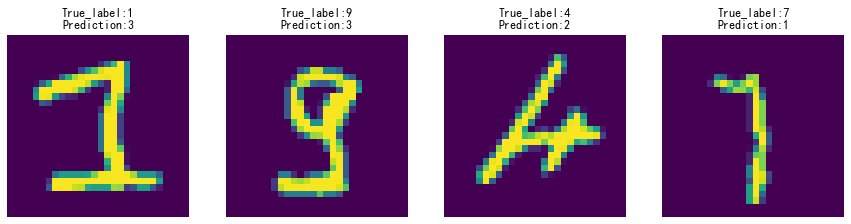

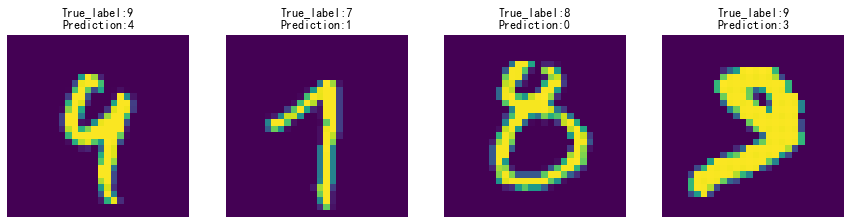

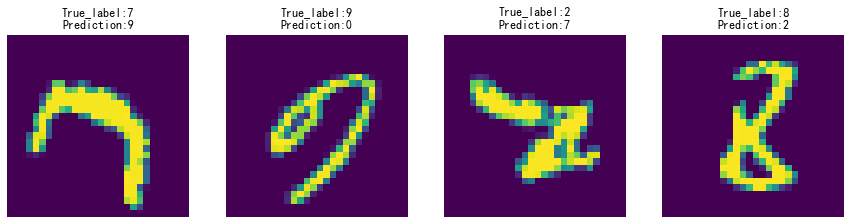

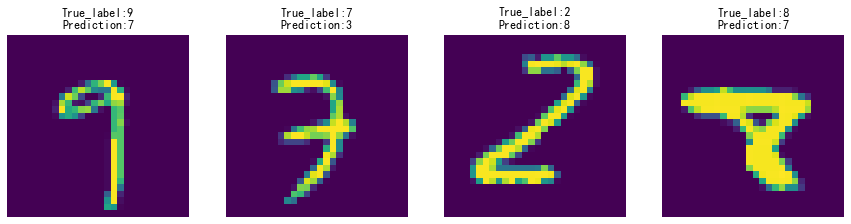

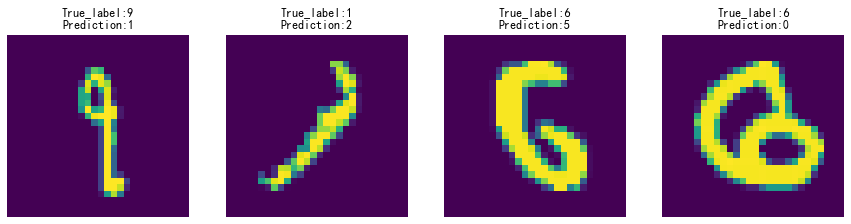

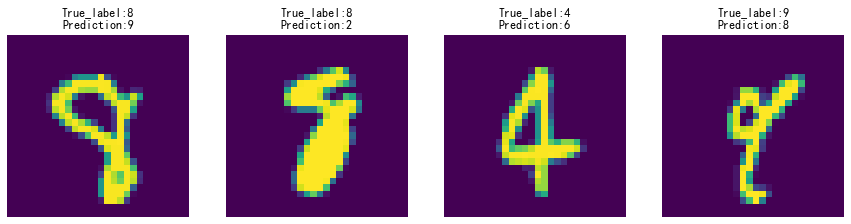

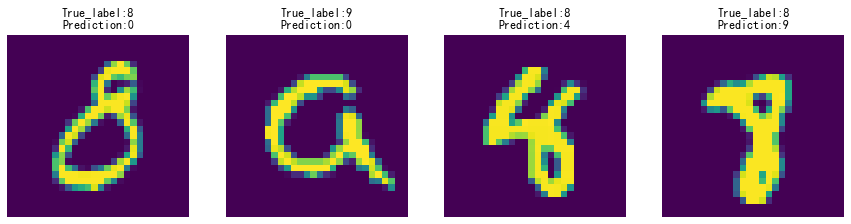

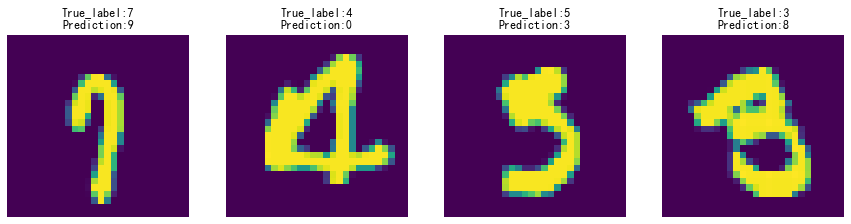

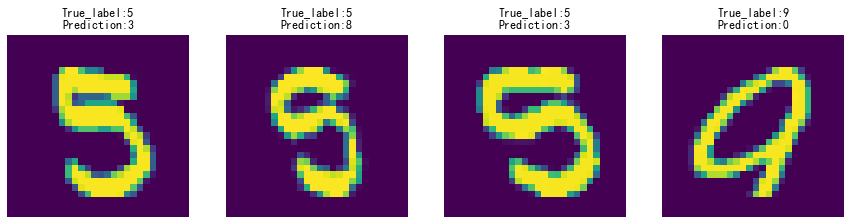

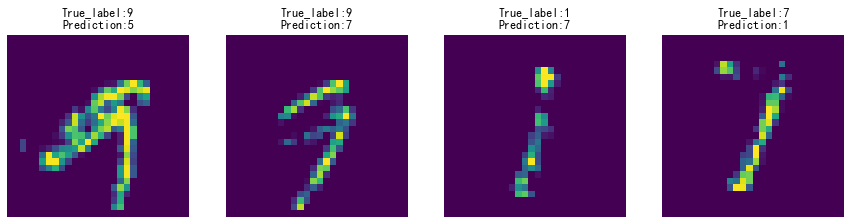

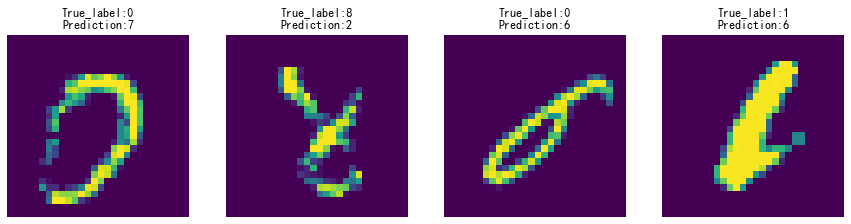

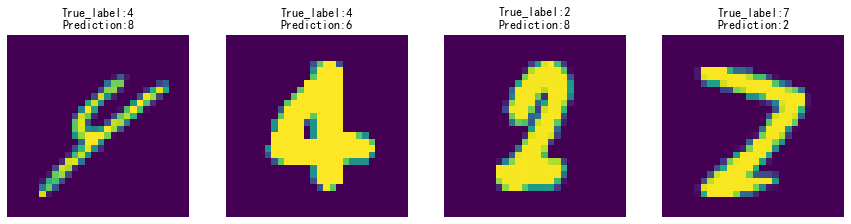

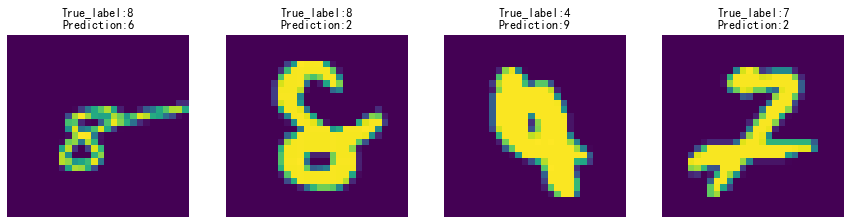

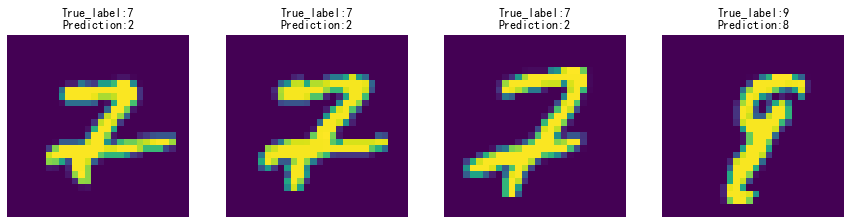

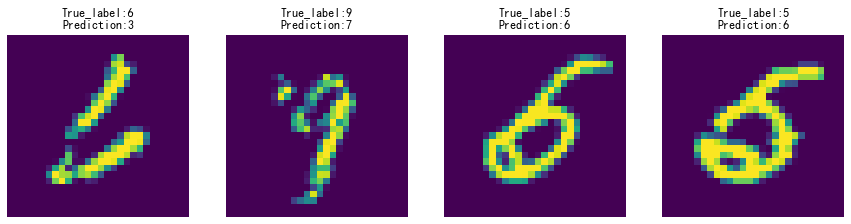

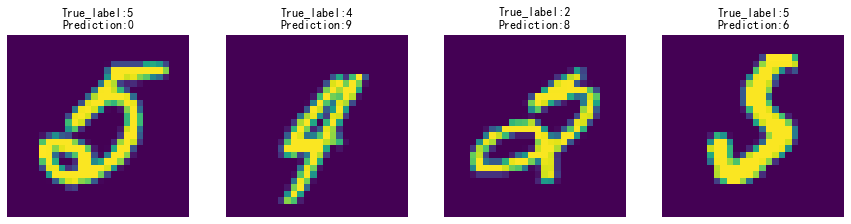

In [35]:
# 展示所有分类错误的图片，以及它们对应的标签和预测结果
for i in range(len(wrong_image_label)):
    plt.style.use({'figure.figsize':(15,15)}) # 设置图像大小
    plt.subplot(1,4,i%4+1) # 绘制一行四列的子图
    plt.imshow(wrong_image[i].reshape((28,28)).cpu().clone().numpy()) # 绘制被分类错误的图片
    title = 'True_label:{}\nPrediction:{}'.format(wrong_image_label[i],wrong_image_pred[i]) # 图表标题说明图片的正确标签和错误结果
    plt.title(title)
    plt.xticks([]) # 关闭刻度线显示
    plt.yticks([])
    plt.axis('off') # 关闭坐标轴显示
    if i%4 == 3: # 凑够一行四个图就显示出来
        plt.show()

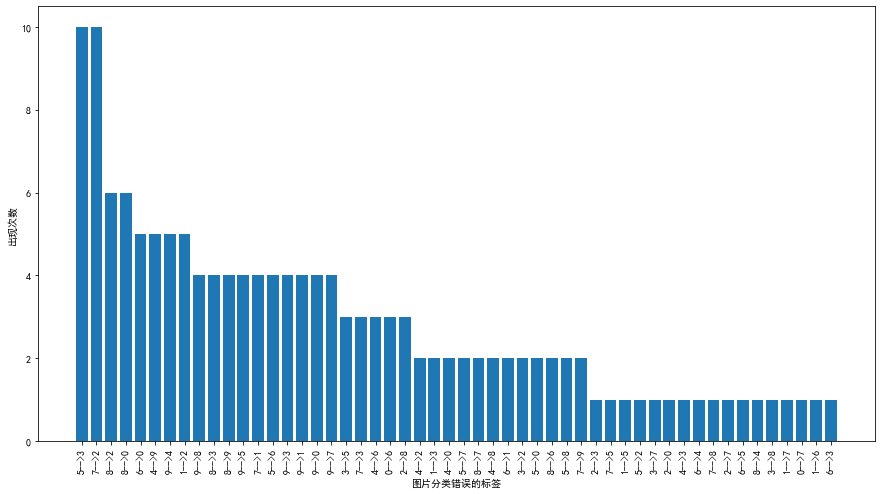

In [36]:
# 分析分类错误的图片，按出现次数降序排列画柱状图

# 构建字典存放分类错误图片的原始标签和预测标签
wrong_pair = dict()
for i in range(len(wrong_image_label)):
    word = f'{wrong_image_label[i]}-->{wrong_image_pred[i]}'
    wrong_pair[word] = wrong_pair.get(word,0) + 1

# 按照分类错误的出现次数排序
items = list(wrong_pair.items())
items.sort(key=lambda x:x[1], reverse=True) 

# 存成csv文件
import csv
with open("wrong_pair.csv","w") as csvfile: 
    writer = csv.writer(csvfile)
    #写入列名
    writer.writerow(["wrong_pair",'counts'])
    for each in items:
        new_row = [each[0],each[1]]
        #写入一行新数据
        writer.writerows([new_row])

import pandas as pd
df = pd.read_csv('wrong_pair.csv')

# 绘制柱状图
plt.style.use({'figure.figsize':(15,8)})
plt.bar(df['wrong_pair'],df['counts'])
plt.xticks(rotation=90)
plt.xlabel('图片分类错误的标签')
plt.ylabel('出现次数')
plt.show()